***Face Mask Detection Classsifier***

***Import Libraries***

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os

***Load Data***

In [70]:
input_data_path = '/content/drive/MyDrive/Colab/Datasets_FaceMask_NoMask.zip (Unzipped Files)/images'
annotations_path = '/content/drive/MyDrive/Colab/Datasets_FaceMask_NoMask.zip (Unzipped Files)/annotations'
image = [*os.listdir("/content/drive/MyDrive/Colab/Datasets_FaceMask_NoMask.zip (Unzipped Files)/images")]
output_data_path = '.'

***Read the annotations file into a Pandas DataFrame***

In [71]:
import xml.etree.ElementTree as ET

def parse_annotation(path):
  tree = ET.parse(path)
  root = tree.getroot()
  constants = {}
  objects =  [child for child in root if child.tag == 'object']
  for element in tree.iter():
    if element.tag == 'filename':
      constants['file'] = element.text[0:-4]
    if element.tag == 'size':
      for dim in list (element):
        if dim.tag == 'width':
          constants['width'] = int(dim.text)
        if dim.tag == 'height':
          constants['height'] = int(dim.text)
        if dim.tag == 'depth':
          constants['depth'] = int(dim.text)

  object_param = [parse_annotation_object(obj) for obj in objects]
  #print(constants)
  full_result = [merge(constants,ob) for ob in object_param]
  return full_result 


def parse_annotation_object(annotation_object):
  params = {}
  for param in list(annotation_object):
    if param.tag == 'name':
      params['name'] = param.text
    if param.tag == 'bndbox':
        for coord in list(param):
            if coord.tag == 'xmin':
              params['xmin'] = int(coord.text)              
            if coord.tag == 'ymin':
              params['ymin'] = int(coord.text)
            if coord.tag == 'xmax':
              params['xmax'] = int(coord.text)
            if coord.tag == 'ymax':
              params['ymax'] = int(coord.text)         
  return params       
 
def merge(dict1, dict2):
  res = {**dict1, **dict2}
  return res

In [72]:
import glob
datasets = [parse_annotation(anno) for anno in glob.glob(annotations_path+"/*.xml") ]

# Since the output of the parse_annotation function is a list of lists, we need to flatten the ctopped faces.
full_dataset = sum(datasets, []) 

data = pd.DataFrame(full_dataset)
data.shape

(4098, 9)

In [73]:
data.head()

,file,width,height,depth,name,xmin,ymin,xmax,ymax
0,maksssksksss103,400,300,3,with_mask,42,54,94,110
1,maksssksksss103,400,300,3,with_mask,188,46,236,106
2,maksssksksss103,400,300,3,with_mask,261,88,303,130
3,maksssksksss103,400,300,3,with_mask,368,112,400,151
4,maksssksksss106,600,399,3,with_mask,154,51,423,391


***Omit one image from the dataset in order to use it at the end of the project for illustrating the results of the model***

In [74]:
test_image = 'maksssksksss89' # chose the image
data_test = data.loc[data["file"] == test_image] # create a separate dataframe which contain only the people in this specific image
image.remove(f'{test_image}.png') # remove the image from the full dataset
data = data.loc[data["file"] != test_image] # remove the information of the image from the full dataset

In [75]:
data_test.head()

,file,width,height,depth,name,xmin,ymin,xmax,ymax
533,maksssksksss89,400,217,3,with_mask,15,101,23,111
534,maksssksksss89,400,217,3,with_mask,47,112,61,127
535,maksssksksss89,400,217,3,with_mask,62,102,85,128
536,maksssksksss89,400,217,3,with_mask,86,102,99,117
537,maksssksksss89,400,217,3,with_mask,117,136,141,159


***Rename some columns***

In [76]:
data.rename(columns = {'file':'file_name','name':'label'}, inplace = True)

data_test.rename(columns = {'file':'file_name','name':'label'}, inplace = True)

In [77]:
data["label"].value_counts()

with_mask                3216
without_mask              730
mask_weared_incorrect     123
Name: label, dtype: int64

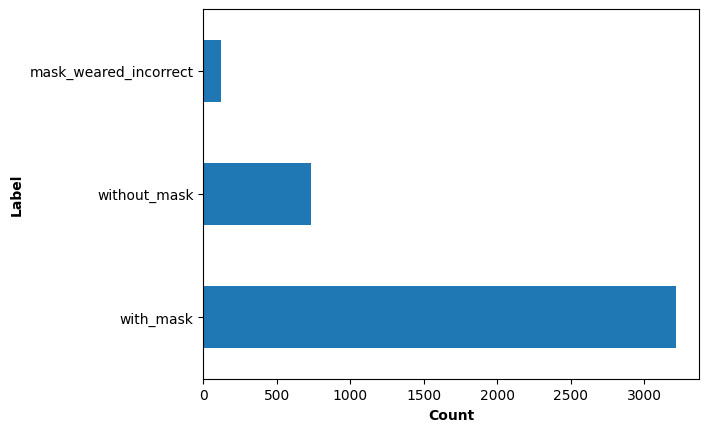

In [78]:
data["label"].value_counts().plot(kind='barh')
plt.xlabel('Count', fontsize = 10, fontweight = 'bold')
plt.ylabel('Label', fontsize = 10, fontweight = 'bold')
plt.show()

***Prepare the data***

In [79]:
labels = data['label'].unique()
dir = ['train','test','validation']
output_data_path = '.'

import os
for label in labels:
  for d in dir:
    path = os.path.join(output_data_path, d, label)
    #print(path)
    if not os.path.exists(path):
      os.makedirs(path)

In [80]:
from PIL import Image
def cropped_img(image_path, X_min, y_min, X_max, y_max):
  X_train = (X_max - X_min) * 0.1
  y_train = (y_max - y_min) * 0.1
  img = Image.open(image_path)
  crop = img.crop((X_min - X_train, y_min - y_train, X_max + X_train, y_max + y_train))
  return crop

***The next function extracts all the people from each image***

In [81]:
def extract_face(img_name, img_info):
  faces = []
  data_image = img_info[img_info['file_name'] == img_name[:-4]][['xmin','ymin','xmax','ymax','label']]
  #print(data_image)
  for row_num in range(len(data_image )):
    X_min, y_min, X_max, y_max, label = data_image.iloc[row_num] 
    image_path = os.path.join(input_data_path, img_name)
    faces.append((cropped_img(image_path, X_min, y_min, X_max, y_max), label,f'{img_name[:-4]}_{(X_min, y_min)}'))
  return faces

In [21]:
cropped_faces = [extract_face(img, data) for img in image]

In [22]:
#flat_cropped_faces = [item for sublist in cropped_faces for item in sublist]
flat_cropped_face = sum(cropped_faces, [])

***Sort the images into their labels according to our 3 classes***

In [23]:
with_mask = [(img, image_name) for img, label, image_name in flat_cropped_face if label == "with_mask"]
mask_weared_incorrect = [(img, image_name) for img, label, image_name in flat_cropped_face if label == "mask_weared_incorrect"]
without_mask = [(img, image_name) for img, label, image_name in flat_cropped_face if label == "without_mask"]

***Sanity check***

In [24]:
print(f'num of images with mask: {len(with_mask)}')
print(f'num of images without mask: {len(without_mask)}')
print(f'num of images incorrect mask: {len(mask_weared_incorrect)}')
print(f'sum: {len(with_mask) + len(without_mask) + len(mask_weared_incorrect)}')

num of images with mask: 3230
num of images without mask: 711
num of images incorrect mask: 123
sum: 4064


***Train (80%) and test (20%). The test set is split again to test (30%) and validation (70%) sets***

In [25]:
from sklearn.model_selection import train_test_split

train_with_mask, test_with_mask = train_test_split(with_mask, test_size=0.2, random_state=42)
test_with_mask, val_with_mask = train_test_split(test_with_mask, test_size=0.7, random_state=42)

train_mask_weared_incorrect, test_mask_weared_incorrect = train_test_split(mask_weared_incorrect, test_size=0.2, random_state=42)
test_mask_weared_incorrect, val_mask_weared_incorrect = train_test_split(test_mask_weared_incorrect, test_size=0.7, random_state=42)

train_without_mask, test_without_mask = train_test_split(without_mask, test_size=0.2, random_state=42)
test_without_mask, val_without_mask = train_test_split(test_without_mask, test_size=0.7, random_state=42)

In [26]:
def save_img(image, img_name, output_data_path,  dataset_type, label):
  output_path = os.path.join(output_data_path, dataset_type, label ,f'{img_name}.png')
  image.save(output_path)

***Save each image in the correct folder***

In [82]:
# Train set
for image, img_name in train_with_mask:
  save_img(image, img_name, output_data_path, 'train', 'with_mask')

for image, img_name in train_mask_weared_incorrect:
  save_img(image, img_name, output_data_path, 'train', 'mask_weared_incorrect')

for image, img_name in train_without_mask:
  save_img(image, img_name, output_data_path, 'train', 'without_mask')
        
# Test set

for image, img_name in test_with_mask:
  save_img(image, img_name, output_data_path, 'test', 'with_mask')

for image, img_name in test_mask_weared_incorrect:
  save_img(image, img_name, output_data_path, 'test', 'mask_weared_incorrect')

for image, img_name_name in test_without_mask:
  save_img(image, img_name, output_data_path, 'test', 'without_mask')
    
# Val set  

for image, img_name in val_with_mask:
  save_img(image, img_name, output_data_path, 'validation', 'with_mask')

for image, img_name in val_without_mask:
  save_img(image, img_name, output_data_path, 'validation', 'without_mask')

for image, img_name in val_mask_weared_incorrect:
  save_img(image, img_name, output_data_path, 'validation', 'mask_weared_incorrect')

***Model Building - CNN***

In [28]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 3,  padding='same', activation = 'relu', input_shape = (35,35,3)))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 64, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 128, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(units = 500, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 3, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 35, 35, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 17, 17, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 64)        9280      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

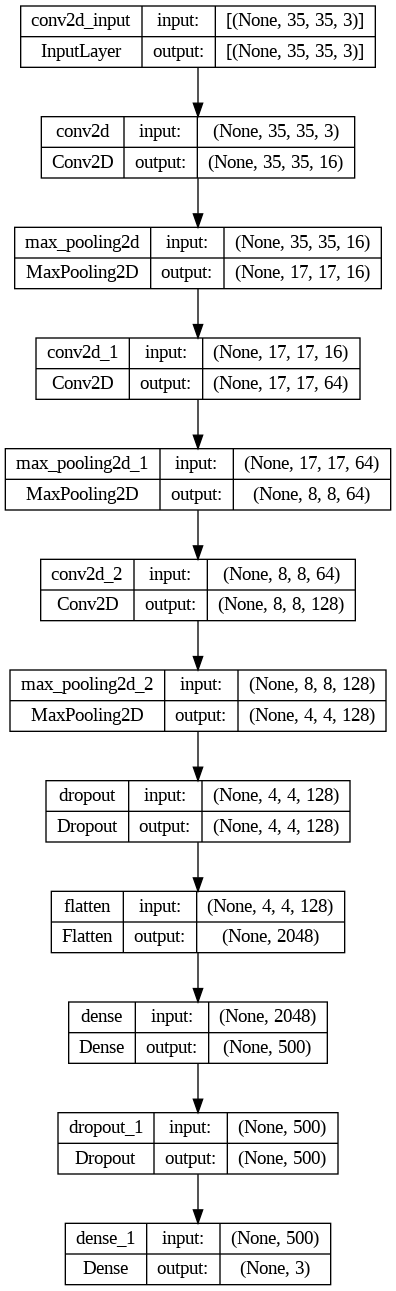

In [29]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

In [30]:
batch_size = 8
epochs = 50

In [83]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
  rescale = 1.0 / 255, horizontal_flip = True, zoom_range = 0.1, shear_range = 0.2, width_shift_range = 0.1,
  height_shift_range = 0.1, rotation_range = 4, vertical_flip = False

)

val_datagen = ImageDataGenerator(
  rescale=1.0 / 255
)

#Train data
train_generator = datagen.flow_from_directory(
  directory = '/content/train', 
  target_size = (35,35),
  class_mode = "categorical", batch_size = batch_size, shuffle = True
)

# Validation data
val_generator = val_datagen.flow_from_directory(
  directory = '/content/validation', 
  target_size = (35,35),
  class_mode = "categorical", batch_size = batch_size, shuffle = True
)

# Test data
test_generator = val_datagen.flow_from_directory(
  directory = '/content/test', 
  target_size = (35,35),
  class_mode="categorical", batch_size = batch_size, shuffle = False
)

Found 3247 images belonging to 3 classes.
Found 572 images belonging to 3 classes.
Found 201 images belonging to 3 classes.


In [84]:
data_size = len(train_generator) 

steps_per_epoch = int(data_size / batch_size)
print(f"steps_per_epoch: {steps_per_epoch}")

val_steps = int(len(val_generator) // batch_size)
print(f"val_steps: {val_steps}")

steps_per_epoch: 50
val_steps: 9


In [34]:
# Compiling the model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy', 'Recall', 'Precision']
)

***Early Stopping***

In [35]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

***Reduce Learning Rate On Plateau***

In [37]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lrr = ReduceLROnPlateau(monitor='val_loss',patience=8,verbose=1,factor=0.5, min_lr=0.0000001)

In [38]:
model_history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    shuffle=True,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=[early_stopping, lrr]
)

<ipython-input-38-b6bd8b88a620>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(


Epoch 1/50
50/50 [==============================] - 15s 33ms/step - loss: 0.6383 - accuracy: 0.7820 - recall: 0.7393 - precision: 0.7973 - val_loss: 0.5330 - val_accuracy: 0.7639 - val_recall: 0.7083 - val_precision: 0.8644 - lr: 0.0010
Epoch 2/50
50/50 [==============================] - 1s 27ms/step - loss: 0.4154 - accuracy: 0.8550 - recall: 0.8225 - precision: 0.8868 - val_loss: 0.2998 - val_accuracy: 0.9306 - val_recall: 0.9306 - val_precision: 0.9306 - lr: 0.0010
Epoch 3/50
50/50 [==============================] - 1s 18ms/step - loss: 0.3400 - accuracy: 0.9000 - recall: 0.8800 - precision: 0.9119 - val_loss: 0.2708 - val_accuracy: 0.9444 - val_recall: 0.9444 - val_precision: 0.9444 - lr: 0.0010
Epoch 4/50
50/50 [==============================] - 1s 18ms/step - loss: 0.3524 - accuracy: 0.8975 - recall: 0.8850 - precision: 0.9054 - val_loss: 0.3249 - val_accuracy: 0.8611 - val_recall: 0.8472 - val_precision: 0.9242 - lr: 0.0010
Epoch 5/50
50/50 [==============================] - 1s 

In [39]:
# Evaluate model performance on test data
model_loss, model_acc, recall, precision = model.evaluate(test_generator)
print("Model has a loss of %.2f and accuracy %.2f%%" % (model_loss, model_acc*100))
print("Model has a recall of %.2f%%, precision of %.2f%%"% (recall*100, precision*100))

26/26 [==============================] - 1s 22ms/step - loss: 0.1452 - accuracy: 0.9502 - recall: 0.9502 - precision: 0.9502
Model has a loss of 0.15 and accuracy 95.02%
Model has a recall of 95.02%, precision of 95.02%


In [40]:
predictions = model.predict(test_generator)
print("predictions shape:", predictions.shape)

26/26 [==============================] - 0s 7ms/step
predictions shape: (201, 3)


In [41]:
def plot_loss_accuracy(history):
  history_data = pd.DataFrame(history)
  fig, ax = plt.subplots(1,2, figsize=(12, 6))
    
  history_data.loc[0:, ['loss', 'val_loss']].plot(ax=ax[0])
  ax[0].set(xlabel = 'Epochs', ylabel = 'loss')

  history_data.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=ax[1])
  ax[1].set(xlabel = 'Epochs', ylabel = 'accuracy')

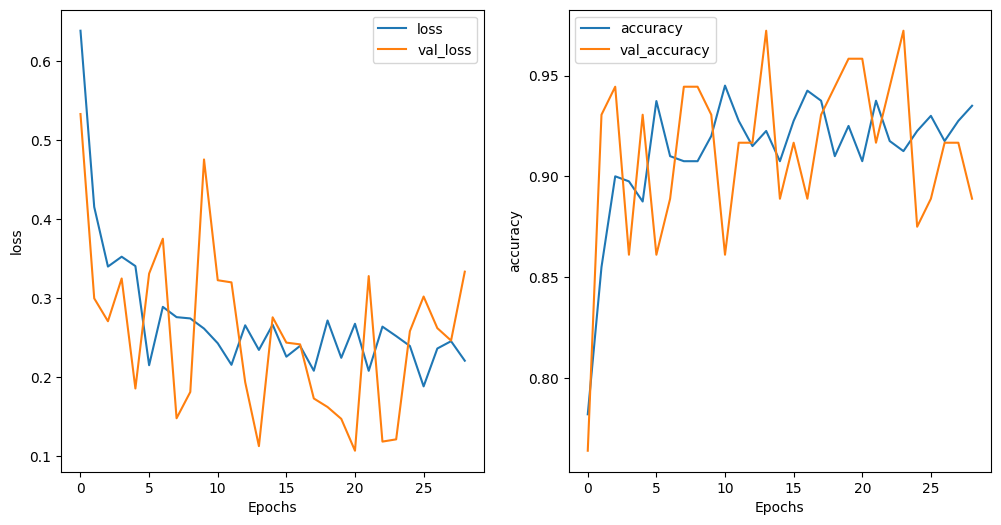

In [42]:
plot_loss_accuracy(model_history.history)

In [43]:
model.save('model_acc.h5')

In [50]:
from tensorflow.keras.models import load_model
model = load_model('/content/model_acc.h5')

***Randomly choose one image from the test set and examine the difference between the original labeling and the model prediction***

26/26 [==============================] - 0s 10ms/step
Class Predicted: with_mask , True label: with_mask


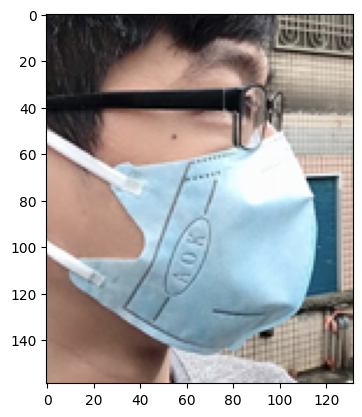

In [62]:
import cv2

paths = test_generator.filenames 

y_pred = model.predict(test_generator).argmax(axis=1) 
classes = test_generator.class_indices  # Map of Indices to Class name

img_rand = np.random.randint(0,len(paths))   # A rand to pick a rand image
img = cv2.imread(os.path.join(output_data_path,'test', paths[img_rand]))      
colored_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  

plt.imshow(colored_img)
true_label = paths[img_rand].split('/')[0]
predicted_label = list(classes)[y_pred[img_rand]]
print(f'Class Predicted: {predicted_label} , True label: {true_label}')

In [63]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, classification_report

import seaborn as sns 

def evaluation(y, y_pred, title = 'Confusion Matrix'):
  cm = confusion_matrix(y, y_pred)
  sns.heatmap(cm,  cmap='Blues', annot=True, fmt='g', annot_kws={'size':20})
  plt.xlabel('predicted', fontsize=15)
  plt.ylabel('actual', fontsize=15)
  plt.title(title, fontsize=15)
    
  plt.show()

26/26 [==============================] - 0s 10ms/step


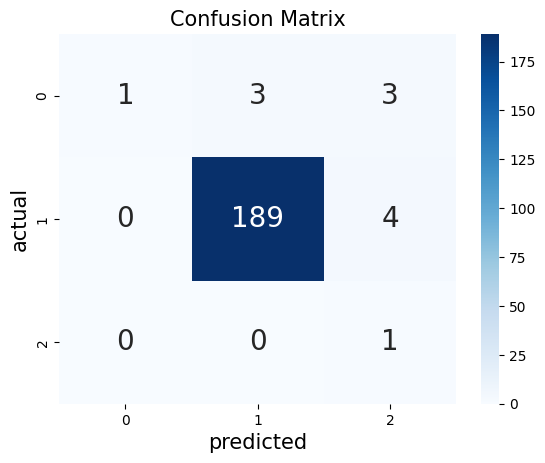

In [64]:
y_true = test_generator.labels
y_pred = model.predict(test_generator).argmax(axis=1) 
evaluation(y_true, y_pred)

In [65]:
classes

{'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2}

In [66]:
np.bincount(y_pred)

array([  1, 192,   8])

***Testing the Results***

1/1 [==============================] - 0s 30ms/step


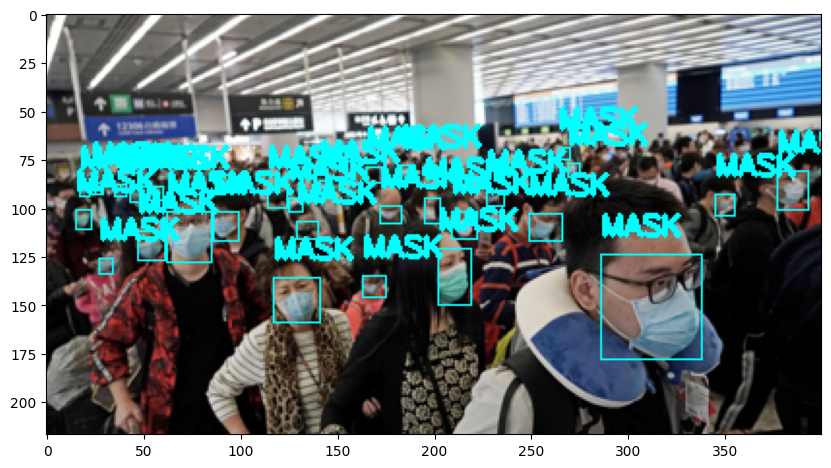

In [85]:
import cv2
img = cv2.imread(os.path.join(input_data_path, f'{test_image}.png'))      
colored_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # colored output image

mask_label = {0:'MASK INCORRECT',1:'MASK', 2:'NO MASK'}
color_label = {0:(0,255,0),1:(0,255,255), 2:(255,0,0)}
cropped_faces = extract_face(f'{test_image}.png', data_test)

test_img = data_test[['xmin', 'ymin', 'xmax', 'ymax', 'label']]

for idx, face in enumerate(cropped_faces):    
  X_min, y_min, X_max, y_max, label = test_img.iloc[idx] 

  resized_face = cv2.cvtColor(resized_face, cv2.COLOR_RGB2BGR)
  resized_face = cv2.resize(resized_face, (35, 35))
  
  #resized_face = cv2.resize(np.array(face[0]),(35,35))
  reshaped_face = np.reshape(resized_face,[1,35,35,3])/255.0
  face_result = model.predict(reshaped_face)

  cv2.putText(colored_img,mask_label[face_result.argmax()],(X_min, y_min-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,color_label[face_result.argmax()],2)
  cv2.rectangle(colored_img,(X_min, y_min), (X_max, y_max), color_label[face_result.argmax()]) # print a blue rectangle of each person's face using the given coordinates

plt.figure(figsize=(10, 10))    
plt.imshow(colored_img)